## Launching on IonQ

Import libraries

In [195]:
import numpy as np
import pennylane as qml
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from pennylane import numpy as pnp

import jax
import jax.numpy as jnp
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from pennylane_qiskit import AerDevice
from pennylane_ionq import ops
from qiskit_aer import AerSimulator


jax.config.update("jax_enable_x64", True)

import optax

Circuit function layer thing

In [196]:
def qdi_layer(parameters):
    param_index = 0
    m = 1
    d = 4
    
    for i in range(m):
        # Apply parameterized gates
        for qubit in range(n_qubits):
            qml.RX(parameters[param_index], qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

    for i in range(d):
        for qubit in range(n_qubits):
            qml.RZ(parameters[param_index], qubit)
            param_index += 1

        for j in range(m):
            # Apply parameterized gates
            for qubit in range(n_qubits):
                qml.RX(parameters[param_index], qubit)
                param_index += 1
            # Apply CNOT gates for entanglement
            for qubit in range(n_qubits - 1):
                qml.CNOT(wires=[qubit, qubit + 1])
            qml.CNOT(wires=[n_qubits - 1, 0])

    return qml.probs(wires=range(n_qubits))


In [197]:
def pqn_layer(parameters):
    param_index = 0
    i = 6
    for qubit in range(n_qubits):
            qml.RX(parameters[param_index %163], qubit)
            param_index += 1
    
    for k in range(i):
        # Apply parameterized gates
        for qubit in range(n_qubits):
            qml.RZ(parameters[param_index %163], qubit)
            param_index += 1
            qml.RY(parameters[param_index %163], qubit)
            param_index += 1
            qml.RZ(parameters[param_index %163], qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

    return qml.probs(wires=range(n_qubits))



In [198]:
def efq_layer(parameters):
    param_index = 1
    x = parameters[0]
    n = 6
    for k in range(n):
        #W part
        for qubit in range(n_qubits):
            qml.RY(parameters[param_index], qubit)
            param_index += 1
            qml.RZ(parameters[param_index], qubit)
            param_index += 1
            qml.RX(parameters[param_index], qubit)
            param_index += 1

            qml.RZ((2**k + 1)*x, qubit)
            
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    return qml.probs(wires=range(n_qubits))


In [199]:
def strong_layer(parameters):
    #circuit = strong_layer(n_qubits, params, 6)
    #measurements = qml.from_qiskit(circuit)()
    param_index=0
    for i in range(6):
        for qubit in range(n_qubits):
            qml.RX(parameters[param_index], wires=qubit)
            param_index += 1
            qml.RY(parameters[param_index], wires=qubit)
            param_index += 1
            qml.RZ(parameters[param_index], wires=qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    return qml.probs(wires=range(n_qubits))

Generate Bars and Stripes dataset

In [200]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)
    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))


n = 3
size = n**2
n_qubits = size
data = get_bars_and_stripes(n)

bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)



Define the device used

In [216]:
dev = qml.device("ionq.simulator", wires=n_qubits, api_key="iRpYWZL97FtKxQRHyGZZU5lgbnhEwAZj")
#dev = qml.device("ionq.qpu", wires=n_qubits, api_key="iRpYWZL97FtKxQRHyGZZU5lgbnhEwAZj")

Trained on simulations parameters

In [202]:
params_strong = np.array([
0.4936017838523216 ,
-1.0156403682513968 ,
-0.4226938781921177 ,
-0.33363826510824796 ,
0.5612076503970502 ,
0.8959563481895698 ,
2.8029183736228354 ,
0.7448412542746075 ,
1.1888240469701026 ,
0.1280844397317628 ,
-0.09927121192738098 ,
0.5862313689692779 ,
-0.3677286939594024 ,
1.454589366565487 ,
0.9008829410635578 ,
-0.010999153251764477 ,
0.020297035605405783 ,
0.037149166688311544 ,
0.2598829202389302 ,
1.0940511586374175 ,
0.4414030377961125 ,
0.2693783209573075 ,
-0.8260711713661884 ,
-0.12763935733211104 ,
0.2730890103550099 ,
0.10702245102335174 ,
0.05144339755417955 ,
-0.19256597737890246 ,
-0.7392066726962767 ,
0.9710720491656045 ,
-0.47088862962875166 ,
0.1216856363128208 ,
1.1748897561831448 ,
0.3035573781308312 ,
1.5754382182994637 ,
0.3036930231821299 ,
1.5896291443714887 ,
1.4912179020098943 ,
0.06513885762593064 ,
1.5851825745160317 ,
0.8325007785599079 ,
1.589068138753211 ,
0.5958164528915538 ,
1.5507399963225856 ,
2.1518239942336925 ,
-0.4095735913693838 ,
-0.23159032049683045 ,
0.6986870157526407 ,
0.013747571656682977 ,
2.056802424480284 ,
-0.7972075442354568 ,
0.9061507493573308 ,
-0.7250811531455158 ,
0.09442196497069748 ,
1.7818902924507611 ,
-0.04717416455903923 ,
0.38960970846457854 ,
3.0790883765065074 ,
1.0342181759972975 ,
1.7397686971566326 ,
1.59874650635037 ,
0.0003724411062938804 ,
0.8379598371604017 ,
-0.15339108626855152 ,
-0.001110999369777623 ,
1.7573386275187233 ,
0.056128306182154156 ,
1.8842265796415134 ,
1.610151373181949 ,
1.555671416922295 ,
1.5071072258443676 ,
-0.03489416146614487 ,
1.670932993330223 ,
0.09259353565775046 ,
-0.43983427630759814 ,
-0.500499017215944 ,
1.100644692052728 ,
-0.9002218645051019 ,
0.8174834345113544 ,
1.2005757851367123 ,
0.03297314734914525 ,
-1.5014355244345845 ,
0.9850747488764025 ,
-1.2443108894026216 ,
1.4198981786969338 ,
1.525172799106486 ,
1.4209137247852404 ,
-0.6599647700578555 ,
0.3946706947196962 ,
-0.7883026730483704 ,
1.854151648494687 ,
1.5684778055013675 ,
0.26946373366564486 ,
0.01229936847587357 ,
0.6653333030465189 ,
0.006565023538170076 ,
-1.4247187134287524 ,
1.5747762168423842 ,
0.14688239599028993 ,
1.1094755972454418 ,
-0.8599665824008957 ,
0.5964739993263569 ,
0.9429098312578964 ,
1.0817033742450264 ,
0.3700142547055241 ,
0.5113793053226777 ,
0.6139874824472414 ,
0.6417825636206158 ,
0.3932517827700829 ,
1.055767204313842 ,
-0.06000417807492659 ,
-0.2571318704269079 ,
0.006624430904519752 ,
0.0011023201572409526 ,
0.004188461691840937 ,
-0.7039234327343971 ,
-0.00021878402171395016 ,
0.00022456199318883285 ,
0.004830178422937499 ,
-0.7894790483897186 ,
0.3886779252156111 ,
1.580033433614213 ,
1.5972783428613473 ,
-0.000411334013083513 ,
0.007589791768124221 ,
-0.8421256403002798 ,
-0.16843388887458538 ,
1.3424598805620096 ,
1.0862083820421424 ,
0.15296789284435916 ,
0.49515408368514563 ,
-0.20024183021967915 ,
-1.1829256510267343 ,
0.5854300661175993 ,
-0.2583219760937691 ,
-0.053514710671101993 ,
0.2864221522073595 ,
0.6226363264148131 ,
3.570425407457916 ,
1.568284866884721 ,
0.7251440392896135 ,
-0.0038617466725323307 ,
-0.0013567380411063684 ,
0.7318665685225513 ,
0.005095857534427313 ,
-0.0009769908597556862 ,
0.7995411864142021 ,
0.32677396161287137 ,
0.5956646536635773 ,
0.7163290823944736 ,
-0.010591514659271273 ,
-0.0061660812859822365 ,
0.5534786433218812 ,
-0.7830477565645507 ,
0.18017273813233425 ,
0.4632493681097552 ,
-0.5524451946688894 ,
0.3647380312150165 ,
0.14162352848889215 ,
-0.5380132490467762 ,
1.064481334187658 ,
0.42653102493508266 ,
0.40167081718880526 ,
]
)

params_qdi = np.array([
0.004724092624215492 ,
0.0031293864652805824 ,
-0.0077927370183442715 ,
-0.02452800281250142 ,
0.030187968942875402 ,
-1.2334262954376878 ,
0.10961767427442369 ,
1.3871655953669009 ,
-1.4024504190680278 ,
0.14898634524370086 ,
0.18042967651306846 ,
-0.36512298743276617 ,
-1.6222490228521766 ,
-0.49780216690959195 ,
0.7155538187455511 ,
-0.011238508696877082 ,
1.2184706180717964 ,
0.7672755372859883 ,
2.0352257978498023 ,
0.19880805602545004 ,
1.0027620930508487 ,
-0.3073206986774117 ,
0.20753050416429206 ,
1.8098100782839932 ,
1.840981991744365 ,
1.593424071370052 ,
1.8360477156241326 ,
-0.8262017154096205 ,
1.2532497943521013 ,
0.3023306559933918 ,
-1.0568451990304875 ,
-0.7028912805963877 ,
1.3540797061954981 ,
-0.02485118258785591 ,
-0.25023434316805804 ,
-0.5399125771975509 ,
0.0611895559196433 ,
-0.2108896194535303 ,
0.009510479752588749 ,
-0.016658164675040256 ,
0.02444441098886235 ,
-0.2553177370682766 ,
1.7217412529411287 ,
-1.084351694934314 ,
-0.03356510478045135 ,
1.0107887000017861 ,
-0.08074362589553154 ,
-1.2395687086535452 ,
0.31841458109143217 ,
0.3629214026703 ,
-0.18356284529604863 ,
-0.03690044728888447 ,
0.9168194443624876 ,
1.61780369668223 ,
0.7613933279651949 ,
0.045007625803493385 ,
0.013253314349627416 ,
-0.2760134339918769 ,
-0.022911302577256983 ,
1.3773948646509613 ,
1.481230338704525 ,
-0.077637641092384 ,
0.07237428541577169 ,
0.17797121059438906 ,
-0.40221332278285665 ,
-0.5063842526871677 ,
-0.39915655249338744 ,
3.3956144511805753 ,
-0.08438803927131755 ,
0.3016634367277811 ,
1.6182174379959096 ,
0.3634517047300957 ,
-0.05005018818821254 ,
-1.5692855102839702 ,
0.031053989685102562 ,
0.10959232415584372 ,
-0.22497138379004777 ,
1.3982209292105319 ,
-0.03323391862464664 ,
1.4479420777059786 ,
-0.013418357777413301 ,
0.6241721165178502 ,
0.8674348807072428 ,
0.16058908198213062 ,
0.43474850361094797 ,
0.46614664818089413 ,
0.4704133081718759 ,
0.5987608006586564 ,
0.8320527898566099 ,
0.032755787206894205 ,
0.9439599871320533 ,
0.08918671209589113 ,
0.17564200603080293 ,
0.13064595432050297 ,
0.8656737412866373 ,
0.4776271960887869 ,
0.453109500694168 ,
0.4589537083652664 ,
0.1268865554370503 ,
0.5911027024762061 ,
0.5142394586204115 ,
0.4491044153890098 ,
0.41617917159978646 ,
0.971471966034779 ,
0.1601459732273276 ,
0.5426751255906315 ,
0.15182451158500654 ,
0.37214687119594114 ,
0.9142102228715616 ,
0.4835208763463744 ,
0.7220089202756148 ,
0.12566603284409628 ,
0.7565574089745597 ,
0.39154767793389167 ,
0.39230817876148794 ,
0.3751049802973391 ,
0.16547550228606256 ,
0.4973256191341753 ,
0.19826228932014167 ,
0.02394060624120098 ,
0.3819794436179357 ,
0.23154249449839726 ,
0.48006780654476355 ,
0.6784491463948895 ,
0.7087457805469757 ,
0.427577770925587 ,
0.3328063885793675 ,
0.7571724287375341 ,
0.18123115784143407 ,
0.8972013544376578 ,
0.7596974032760543 ,
0.45958716845719216 ,
0.1885828877778163 ,
0.6002356548166816 ,
0.09301263438575924 ,
0.14118554743735168 ,
0.1920605774926183 ,
0.6226363264191664 ,
0.8183509321857526 ,
0.2232797507387334 ,
0.7251440393637774 ,
0.7629481187428562 ,
0.5207120664184572 ,
0.7318665685099482 ,
0.9500195332298572 ,
0.6868902201945143 ,
0.7995411864066545 ,
0.5341751487557536 ,
0.986512892977617 ,
0.7163290823798459 ,
0.9233935939365223 ,
0.8893073749948306 ,
0.5534786433819772 ,
0.08125844213668953 ,
0.7538146636216422 ,
0.4632493681639479 ,
0.6242203060894439 ,
0.8880823711040603 ,
0.14162352847875204 ,
0.3614157869169534 ,
0.9779506836943674 ,
0.4265310249390999 ,
0.40167081718880526 ,
]
)



params_pqn = np.array(
[ 8.36737412e-01,  9.60883769e-01,  5.50615877e-03,  5.09183532e-01,
  3.00421283e-01,  6.31111945e-01,  5.09010627e-01,  4.55114790e-01,
 -1.48529835e+00,  5.86036421e-01,  9.76476468e-01,  5.42780166e-01,
 -5.73448357e-01,  3.85417034e-01, -8.09868547e-02,  1.30528544e+00,
 -1.23868175e-04,  1.54488276e+00,  8.79244275e-01,  1.66258533e+00,
  5.19496013e-01,  4.90367997e-01, -3.59915978e-01,  1.20578262e+00,
  7.70672983e-01,  9.47626379e-01,  5.56506335e-01,  1.54710633e-01,
  6.30991600e-01,  2.24060939e-01, -6.68261949e-02,  6.59963418e-01,
  6.90121809e-01, -1.14868378e+00,  1.10560575e+00, -8.55545521e-01,
  5.44430525e-01, -1.09223963e+00,  5.90476141e-01,  9.73537316e-01,
  1.57063561e+00, -1.86765473e-03,  7.24782309e-01,  1.57595355e+00,
  1.56819495e+00, -4.54076552e-01,  8.20936931e-02,  5.81189997e-01,
  1.48950531e+00,  1.31922727e+00,  7.74433207e-02, -6.36675222e-01,
 -8.88222510e-01,  3.98814786e-02,  1.09302820e+00, -4.07875266e-03,
  3.37186784e-01, -3.86868770e-02,  9.13690032e-01, -3.25991565e-02,
 -2.68991471e-01,  7.36670514e-01,  1.65761730e+00, -2.26551504e-03,
  1.57214437e+00,  6.65647017e-01,  1.01158629e+00,  1.99029182e-02,
  5.60288115e-01,  1.50413080e+00,  1.57128661e+00,  2.11729279e-03,
  6.42861929e-01,  9.64505308e-02,  9.80338910e-01, -4.38721757e-01,
  1.35055024e-02,  3.50015167e-01,  4.20035564e-02,  1.56440617e+00,
 -5.52814223e-01, -2.27757713e-02,  1.54796785e+00,  6.20408720e-01,
  1.60455792e+00,  9.25590375e-01,  2.42925383e-02,  9.69653702e-01,
 -1.30039793e-01,  6.06044715e-01,  2.88529275e-01,  9.00967787e-03,
  5.93136000e-01, -6.83315275e-04,  1.58310987e+00,  1.20336363e-01,
  1.67205929e-01,  7.74723213e-01,  1.34812985e+00,  4.85532104e-01,
  1.06450073e-01,  1.08213206e+00,  3.51807967e-01,  1.57379482e+00,
 -7.22854844e-02, -1.79759337e-02,  1.05931164e+00, -7.49595570e-02,
 -4.58986370e-01,  1.52129901e+00,  1.46461604e+00,  1.70408727e+00,
  9.77657311e-01, -1.73587609e+00,  1.35837013e-01,  1.59754700e+00,
 -3.72472118e-02, -1.07511615e-01,  1.88463284e-04, -4.90414842e-01,
 -9.95963183e-02, -2.88971097e-03, -1.68042170e-01, -1.54160226e-02,
  1.59585032e+00,  2.20256063e+00,  3.81324973e-01,  1.93834027e-01,
  7.61372354e-01,  1.35632987e+00, -2.12183669e-01,  2.20986975e-01,
  8.47893237e-03,  1.54969943e+00,  5.81632835e-02, -1.56499493e+00,
  9.06048817e-01,  3.14866294e+00,  4.73253437e-02,  1.42051394e+00,
  3.30246737e-01,  1.19504540e+00, -1.07055368e-03,  1.29771472e+00,
  1.63497687e+00,  8.65419849e-02,  7.99541186e-01,  4.12115588e-01,
  1.57145673e+00,  7.16329082e-01,  1.86899874e+00, -2.30397387e-02,
  5.53478643e-01,  8.87283381e-01,  1.36604608e-02,  4.63249368e-01,
  2.48693764e-02,  1.59681822e+00,  1.41623528e-01,  5.88370345e-03,
  1.56925587e+00,  4.26531025e-01, -8.28376577e-05]
)
params_efq = np.array([
0.9214336035682655 ,
-0.2627006684434099 ,
-0.3324087331453656 ,
0.4753854848418269 ,
1.165886332151684 ,
1.250861740795562 ,
-0.4187982874409886 ,
-0.11507035954822595 ,
1.8740661559826988 ,
-0.0643784657364488 ,
0.5364765462701799 ,
0.10337760969197779 ,
0.23037812474395275 ,
0.7142635496858422 ,
1.0266668850902823 ,
0.23243548590899568 ,
-0.3410325308226195 ,
0.6106787853425605 ,
1.3675347295050004 ,
1.0829736494312228 ,
-0.05742138841360796 ,
1.522985028664261 ,
-0.09816477019157309 ,
0.4663598038668618 ,
0.5526267307232736 ,
0.8243630489431 ,
0.1866321850207292 ,
0.09773192431051647 ,
-0.17471246793332307 ,
0.22856788189693078 ,
0.5559242077644727 ,
0.02899772941676228 ,
1.11539579867281 ,
0.13499858602516668 ,
0.08779257057858597 ,
1.4502753188156936 ,
0.08067396078030908 ,
-0.02163077754096449 ,
1.570013873560675 ,
-0.032379019647066035 ,
0.020326226714976803 ,
0.41268154110665445 ,
0.041227617455440485 ,
0.9809791325075146 ,
-0.2885291816148128 ,
-1.0796522576215342 ,
0.4356216053298245 ,
1.0343843862721238 ,
-0.23974988232327354 ,
1.643721320505522 ,
-0.867616053664403 ,
0.009343534235220063 ,
-1.2811675571216838 ,
0.44833026179301083 ,
-0.06828379971872765 ,
-0.6705487216593923 ,
-0.23142821837892105 ,
1.183009165787018 ,
1.5253239004226522 ,
0.4801599872210964 ,
0.06520444568947616 ,
-0.05644995969269115 ,
2.0632932180510344 ,
1.35148204045764 ,
1.352690952847003 ,
1.2680930953112204 ,
-0.12356075579737019 ,
0.8387711889492484 ,
-0.5598918755623351 ,
-0.47049325173859974 ,
0.8640170291989321 ,
-0.8942447892435018 ,
0.7226579317416654 ,
-0.015351150111781064 ,
0.008558183505895394 ,
-0.049626539104925475 ,
1.8553028513587497 ,
0.3273144971832777 ,
1.4929943241604688 ,
1.2762563640493458 ,
0.6388794449894912 ,
-0.035498793047043425 ,
-0.0040630506757890145 ,
-0.6547043240049655 ,
-0.01219460060345183 ,
0.7892495645169624 ,
0.9631823194582869 ,
0.8753397852980066 ,
-0.4493852981106076 ,
-0.1495894839090842 ,
1.2568414777229353 ,
-0.4496465606021879 ,
0.3308361451468284 ,
1.415358255715011 ,
1.1111588514407014 ,
0.9393528380542967 ,
0.8479446476410195 ,
1.1143238859206814 ,
0.7348479853181957 ,
0.4391152993473555 ,
1.6347101620249682 ,
-0.07375813559738649 ,
0.2059974396909442 ,
0.6854835754433174 ,
0.0029105865596822135 ,
1.2314905141340644 ,
-0.5138876335055198 ,
0.5987368366562217 ,
1.2821528971882035 ,
1.6100411238079955 ,
0.5045548391435062 ,
1.5734949476245794 ,
1.310956156759287 ,
1.5651566287041447 ,
1.274140156139419 ,
0.20186911435289093 ,
1.776115350112471 ,
0.20743198705844793 ,
-0.41099137224000504 ,
0.5515657941546331 ,
-0.46109517485452917 ,
-0.044123276712499514 ,
-0.2686599558936618 ,
0.34437355221205507 ,
1.5312468017346386 ,
0.9631556977705406 ,
0.049065475346012015 ,
0.9076541966619647 ,
-0.09343815302644669 ,
1.0786741004028826 ,
-0.12237043482875129 ,
0.563615867678479 ,
0.15478285072889184 ,
0.01828228853802471 ,
0.08389890839605538 ,
0.328853320663686 ,
-0.17150468674697913 ,
0.8945703300575185 ,
0.5942456908221171 ,
-0.10860072484480175 ,
1.1255017235422082 ,
-0.1316028318367221 ,
0.03684554570366964 ,
1.4254752081272 ,
0.03474868830756801 ,
0.06638172643843109 ,
0.864326123895283 ,
-0.45203242021593776 ,
1.3554739829135953 ,
0.9304870013851312 ,
0.5672217103520922 ,
2.0068097463893735 ,
-1.3255178153623126 ,
0.9899051204719119 ,
0.4272952362911456 ,
0.42589350943778276 ,
1.0641945870167213 ,
0.6458020436321233 ,
-1.0546150849910911 ,
0.030316073363525334 ,
1.6857834527392765 ,
-1.6803819927763353 ,
-0.1141275743225234
]
)




Launch on IONQ

In [203]:
@qml.qnode(dev)
def circuit_strong(parameters):
    return strong_layer(parameters)
    
output_probs_strong = circuit_strong(params_strong)



In [204]:
@qml.qnode(dev)
def circuit_qdi(parameters):
    return qdi_layer(parameters)
    
output_probs_qdi = circuit_qdi(params_qdi)


In [205]:
@qml.qnode(dev)
def circuit_pqn(parameters):
    return pqn_layer(parameters)
    
output_probs_pqn = circuit_pqn(params_pqn)


In [206]:
@qml.qnode(dev)
def circuit_efq(parameters):
    return efq_layer(parameters)
    
output_probs_efq = circuit_efq(params_efq)


Plot histograms

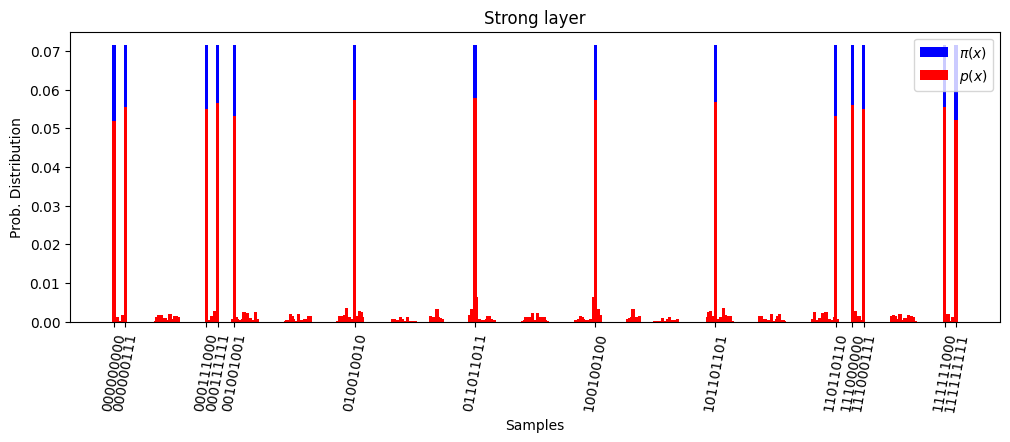

In [207]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs_strong, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.title("Strong layer")
plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of Strong layer

In [208]:
acr=0
for i in nums:
    acr+=output_probs_strong[i]
print(acr)

0.7732355303585227


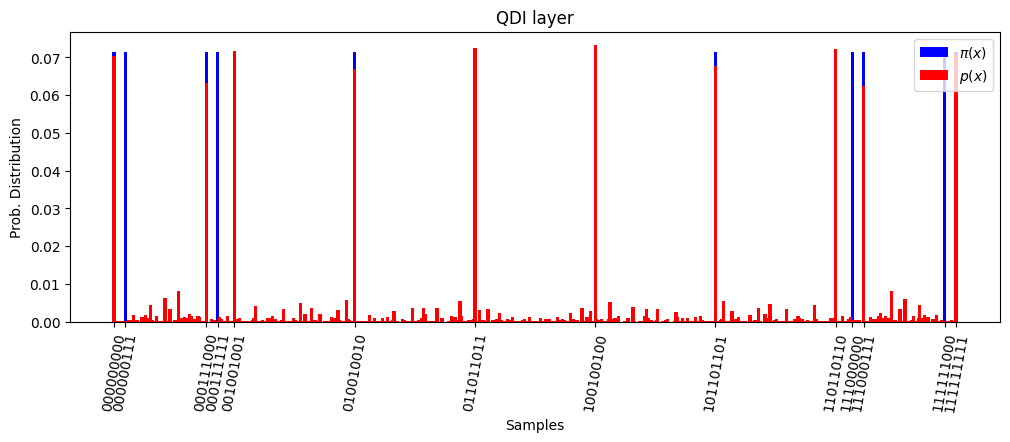

In [209]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs_qdi, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.title("QDI layer")
plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of QDI layer

In [210]:
acr=0
for i in nums:
    acr+=output_probs_qdi[i]
print(acr)

0.6918550827674194


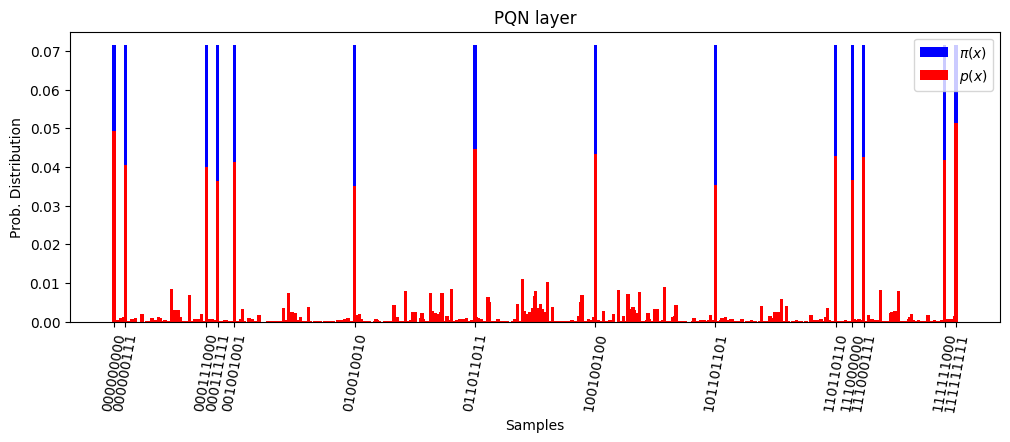

In [211]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs_pqn, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.title("PQN layer")
plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of PQN layer

In [212]:
acr=0
for i in nums:
    acr+=output_probs_pqn[i]
print(acr)

0.5807780510961097


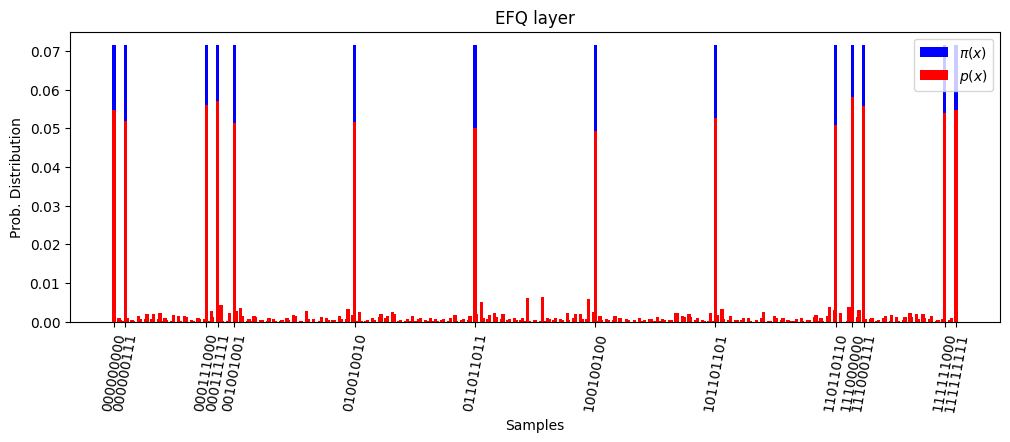

In [213]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs_efq, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.title("EFQ layer")
plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of EFQ layer

In [214]:
acr=0
for i in nums:
    acr+=output_probs_efq[i]
print(acr)

0.7483992936453966
